### This code was written solely by Mohammadreza Khodajou Masouleh and Lukas Trakimas.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [ ]:
import numpy as np

In [ ]:
class Model(nn.Module):

  # Input layer contains 30x2 neurons (city coordinates) + 1 extra neuron (relaxation parameter)
  # Output layer contains 2 neurons (probability of feasable solution and expected distance)

  def __init__(self, in_features=30*2 + 1, h1=64, h2=64, h3=32, out_features=2):
    dropout = 0.4
    super().__init__() # instantiate nn.Module
    self.fc1 = nn.Linear(in_features, h1)
    self.bn1 = nn.BatchNorm1d(h1)
    self.dropout = nn.Dropout(dropout)
    self.fc2 = nn.Linear(h1,h2)
    self.bn2 = nn.BatchNorm1d(h2)
    self.dropout = nn.Dropout(dropout)
    self.fc3 = nn.Linear(h2,h3)
    self.bn3 = nn.BatchNorm1d(h3)
    self.dropout = nn.Dropout(dropout)
    self.out = nn.Linear(h3,out_features)

  def forward(self, x):
    x = torch.sigmoid(self.fc1(x))
    x = self.bn1(x)
    x = self.dropout(x)
    x = torch.sigmoid(self.fc2(x))
    x = self.bn2(x)
    x = self.dropout(x)
    x = torch.sigmoid(self.fc3(x))
    x = self.bn3(x)
    x = self.dropout(x)
    x = torch.sigmoid(self.out(x))
    return x

In [ ]:
model = Model() # instantiate model

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# upload training data
from google.colab import files

uploaded = files.upload()

Saving data.zip to data.zip


In [ ]:
import io
import zipfile

with zipfile.ZipFile(io.BytesIO(uploaded["data.zip"]), 'r') as zip_ref:
    zip_ref.extractall("training-data")

In [ ]:
# upload tsp instances
from google.colab import files

uploaded = files.upload()

Saving instances.zip to instances.zip


In [ ]:
with zipfile.ZipFile(io.BytesIO(uploaded["instances.zip"]), 'r') as zip_ref:
    zip_ref.extractall("instances")

In [ ]:
# clean tsp instance
def extract_coordinates(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()

    coord_section_index = lines.index("NODE_COORD_SECTION \n") + 1

    coordinates = [list(map(float, line.strip().split()[1:])) for line in lines[coord_section_index:]]

    return coordinates

In [ ]:
extract_coordinates("instances/instances/syn_tsp101.tsp")

[[6075.806908831769, 6465.459097028902],
 [1805.7093632409117, 7995.407087240192],
 [5445.28520578996, 4709.201310290762],
 [4958.446922875073, 4673.997127669553],
 [2533.036625960641, 3778.6898032738945],
 [5038.68622672101, 9796.680828742017],
 [6903.350369197077, 4121.00671838615],
 [7731.861596532035, 8600.158557245406],
 [6109.273940377136, 4844.822303021038],
 [5669.766963258698, 6325.045709491309],
 [4203.46698964822, 9567.637308171385],
 [9513.85872348577, 7458.025673101819],
 [8418.091434481072, 2834.239121002633],
 [3805.69633891788, 701.2654225968452],
 [3408.63315541289, 4874.748922237631],
 [3582.4275326243205, 6734.823796827744],
 [7579.383681027281, 8807.636128957125],
 [4465.230672654528, 4254.656775981333],
 [3426.0127567748486, 6253.612203657547],
 [6655.961312536285, 5903.31317428554],
 [6321.242697973241, 5975.006979370272],
 [6949.93866268607, 5136.079762560019],
 [3670.930539292524, 5273.267920504382],
 [8398.719454806347, 1526.1890320388284],
 [8242.731039512464,

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
#from sklearn.preprocessing import StandardScaler
#scaler = StandardScaler()

normalized_data = scaler.fit_transform(extract_coordinates("instances/instances/syn_tsp101.tsp"))

In [ ]:
normalized_data

array([[0.55397182, 0.64177389],
       [0.        , 0.80629831],
       [0.47217246, 0.45291303],
       [0.40901355, 0.44912731],
       [0.09435822, 0.35284958],
       [0.41942323, 1.        ],
       [0.66133137, 0.38966096],
       [0.76881648, 0.87133083],
       [0.55831359, 0.46749716],
       [0.50129511, 0.6266744 ],
       [0.31106787, 0.97536959],
       [1.        , 0.74851048],
       [0.85784301, 0.25128718],
       [0.25946396, 0.02191581],
       [0.20795183, 0.47071535],
       [0.23049867, 0.67074028],
       [0.74903509, 0.89364213],
       [0.34502722, 0.40403315],
       [0.21020654, 0.61899273],
       [0.62923689, 0.58132299],
       [0.5858129 , 0.58903265],
       [0.6673754 , 0.49881781],
       [0.24198041, 0.51357047],
       [0.85532983, 0.11062476],
       [0.83509301, 0.24024476],
       [0.52278943, 0.68423702],
       [0.58651642, 0.41517203],
       [0.86096475, 0.03517713],
       [0.41617046, 0.33532821],
       [0.85045053, 0.        ]])

In [ ]:
# normalize tsp instance
#def normalize_coordinates(coordinates):
#    max_value = max(max(map(abs, row)) for row in coordinates)

#    if max_value == 0:
#        return coordinates

#    normalized_coordinates = [[coord / max_value for coord in row] for row in coordinates]

#    return normalized_coordinates

In [ ]:
#normalize_coordinates(extract_coordinates("instances/instances/syn_tsp101.tsp"))

In [ ]:
# testing combining data into a dataframe for a single instance
coordinates = extract_coordinates("instances/instances/syn_tsp101.tsp")
#nc = normalize_coordinates(coordinates)
flat_coordinates = [coord for sublist in normalized_data for coord in sublist]
idf = pd.DataFrame(data=[flat_coordinates])
ddf = pd.read_csv("training-data/data/syn_tsp101_instance1.csv")


ddf["E_avg"] /= max(max(map(abs, row)) for row in coordinates)

idf_repeated = pd.concat([idf] * len(ddf), ignore_index=True)
new_df = pd.concat([idf_repeated, ddf], axis=1)
new_df

,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,Relaxation Parameter A,Probability P_f,E_avg,E_std,E_min
0,0.553972,0.641774,0.0,0.806298,0.472172,0.452913,0.409014,0.449127,0.094358,0.35285,...,0.035177,0.41617,0.335328,0.850451,0.0,4218.00,0.070312,6.837445,4649.904420,53518.151014
1,0.553972,0.641774,0.0,0.806298,0.472172,0.452913,0.409014,0.449127,0.094358,0.35285,...,0.035177,0.41617,0.335328,0.850451,0.0,4250.82,0.062500,6.815322,4467.012351,54283.345921
2,0.553972,0.641774,0.0,0.806298,0.472172,0.452913,0.409014,0.449127,0.094358,0.35285,...,0.035177,0.41617,0.335328,0.850451,0.0,4283.64,0.054688,6.918838,4606.098256,56801.810406
3,0.553972,0.641774,0.0,0.806298,0.472172,0.452913,0.409014,0.449127,0.094358,0.35285,...,0.035177,0.41617,0.335328,0.850451,0.0,4316.46,0.046875,6.936339,4428.735985,57256.237944
4,0.553972,0.641774,0.0,0.806298,0.472172,0.452913,0.409014,0.449127,0.094358,0.35285,...,0.035177,0.41617,0.335328,0.850451,0.0,4349.28,0.054688,6.930048,4117.578820,57903.136557
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.553972,0.641774,0.0,0.806298,0.472172,0.452913,0.409014,0.449127,0.094358,0.35285,...,0.035177,0.41617,0.335328,0.850451,0.0,7335.90,0.929688,9.148504,7083.258787,74993.455798
96,0.553972,0.641774,0.0,0.806298,0.472172,0.452913,0.409014,0.449127,0.094358,0.35285,...,0.035177,0.41617,0.335328,0.850451,0.0,7368.72,0.945312,9.235136,7504.306268,75748.035340
97,0.553972,0.641774,0.0,0.806298,0.472172,0.452913,0.409014,0.449127,0.094358,0.35285,...,0.035177,0.41617,0.335328,0.850451,0.0,7401.54,0.953125,9.253635,7352.265232,69132.672314
98,0.553972,0.641774,0.0,0.806298,0.472172,0.452913,0.409014,0.449127,0.094358,0.35285,...,0.035177,0.41617,0.335328,0.850451,0.0,7434.36,0.921875,9.220522,7237.830537,70503.720228


In [ ]:
# debugging
#new_df.to_csv('df.csv')
#files.download('df.csv')

In [ ]:

# combining all training data

import os

# training data
training_path = "training-data/data"
training_file_list = sorted(os.listdir(training_path))
csv_files = [file for file in training_file_list if file.endswith('.csv')]

# instances
instance_path = "instances/instances"
instance_file_list = sorted(os.listdir(instance_path))
instance_files = [file for file in instance_file_list if file.endswith('.tsp')]

combined_df = pd.DataFrame()

i = 0
for csv_file in csv_files:
    file_path = os.path.join(training_path, csv_file)
    data_df = pd.read_csv(file_path)

    coordinates = extract_coordinates(os.path.join(instance_path,instance_files[i]))

    #scaler = StandardScaler()
    scaler = MinMaxScaler()
    normalized_coords = scaler.fit_transform(coordinates)

    #normalized_coords = normalize_coordinates(coordinates)
    flat_coordinates = [coord for sublist in normalized_coords for coord in sublist]
    instance_df = pd.DataFrame(data=[flat_coordinates])

    instance_df_repeated = pd.concat([instance_df] * len(data_df), ignore_index=True)
    new_df = pd.concat([instance_df_repeated, data_df], axis=1)

    new_df["E_avg"] /= max(max(map(abs, row)) for row in coordinates) # normalizing the output energy
    #new_df["E_avg"] = scaler.fit_transform(new_df["E_avg"].values.reshape(-1,1))
    combined_df = pd.concat([combined_df, new_df], ignore_index=True)
    i = i + 1

# remove E_std and E_min
combined_df = combined_df.iloc[:, :-2]
combined_df["E_avg"] = combined_df["E_avg"] / combined_df["E_avg"].max()
#combined_df["E_avg"] = scaler.fit_transform(combined_df["E_avg"].values.reshape(-1,1))
combined_df["Relaxation Parameter A"] = scaler.fit_transform(combined_df["Relaxation Parameter A"].values.reshape(-1,1))

In [ ]:
combined_df

,0,1,2,3,4,5,6,7,8,9,...,53,54,55,56,57,58,59,Relaxation Parameter A,Probability P_f,E_avg
0,0.553972,0.641774,0.000000,0.806298,0.472172,0.452913,0.409014,0.449127,0.094358,0.352850,...,0.415172,0.860965,0.035177,0.416170,0.335328,0.850451,0.000000,0.423920,0.070312,0.534859
1,0.553972,0.641774,0.000000,0.806298,0.472172,0.452913,0.409014,0.449127,0.094358,0.352850,...,0.415172,0.860965,0.035177,0.416170,0.335328,0.850451,0.000000,0.427218,0.062500,0.533128
2,0.553972,0.641774,0.000000,0.806298,0.472172,0.452913,0.409014,0.449127,0.094358,0.352850,...,0.415172,0.860965,0.035177,0.416170,0.335328,0.850451,0.000000,0.430517,0.054688,0.541226
3,0.553972,0.641774,0.000000,0.806298,0.472172,0.452913,0.409014,0.449127,0.094358,0.352850,...,0.415172,0.860965,0.035177,0.416170,0.335328,0.850451,0.000000,0.433815,0.046875,0.542595
4,0.553972,0.641774,0.000000,0.806298,0.472172,0.452913,0.409014,0.449127,0.094358,0.352850,...,0.415172,0.860965,0.035177,0.416170,0.335328,0.850451,0.000000,0.437114,0.054688,0.542102
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8495,0.534081,0.650160,0.754381,1.000000,0.914915,0.959476,1.000000,0.341827,0.422104,0.229659,...,0.538619,0.059366,0.438796,0.981874,0.957276,0.320265,0.914407,0.048915,0.984375,0.927583
8496,0.534081,0.650160,0.754381,1.000000,0.914915,0.959476,1.000000,0.341827,0.422104,0.229659,...,0.538619,0.059366,0.438796,0.981874,0.957276,0.320265,0.914407,0.049182,1.000000,0.934811
8497,0.534081,0.650160,0.754381,1.000000,0.914915,0.959476,1.000000,0.341827,0.422104,0.229659,...,0.538619,0.059366,0.438796,0.981874,0.957276,0.320265,0.914407,0.049449,1.000000,0.919593
8498,0.534081,0.650160,0.754381,1.000000,0.914915,0.959476,1.000000,0.341827,0.422104,0.229659,...,0.538619,0.059366,0.438796,0.981874,0.957276,0.320265,0.914407,0.049717,1.000000,0.936231


In [ ]:
X = combined_df.iloc[:, :-2]
#X = combined_df.iloc[:, :-3]
y = combined_df.iloc[:, 61:]

In [ ]:
#X_values = X.values
#y_values = y.values

In [ ]:
X.columns = X.columns.astype(str)

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train , x_test, Y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=100, shuffle=False)
#x_train , x_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=100, shuffle=False)

In [ ]:
X_train.head(10)

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,Relaxation Parameter A
0,0.553972,0.641774,0.0,0.806298,0.472172,0.452913,0.409014,0.449127,0.094358,0.35285,...,0.684237,0.586516,0.415172,0.860965,0.035177,0.41617,0.335328,0.850451,0.0,0.423920
1,0.553972,0.641774,0.0,0.806298,0.472172,0.452913,0.409014,0.449127,0.094358,0.35285,...,0.684237,0.586516,0.415172,0.860965,0.035177,0.41617,0.335328,0.850451,0.0,0.427218
2,0.553972,0.641774,0.0,0.806298,0.472172,0.452913,0.409014,0.449127,0.094358,0.35285,...,0.684237,0.586516,0.415172,0.860965,0.035177,0.41617,0.335328,0.850451,0.0,0.430517
3,0.553972,0.641774,0.0,0.806298,0.472172,0.452913,0.409014,0.449127,0.094358,0.35285,...,0.684237,0.586516,0.415172,0.860965,0.035177,0.41617,0.335328,0.850451,0.0,0.433815
4,0.553972,0.641774,0.0,0.806298,0.472172,0.452913,0.409014,0.449127,0.094358,0.35285,...,0.684237,0.586516,0.415172,0.860965,0.035177,0.41617,0.335328,0.850451,0.0,0.437114
5,0.553972,0.641774,0.0,0.806298,0.472172,0.452913,0.409014,0.449127,0.094358,0.35285,...,0.684237,0.586516,0.415172,0.860965,0.035177,0.41617,0.335328,0.850451,0.0,0.440412
6,0.553972,0.641774,0.0,0.806298,0.472172,0.452913,0.409014,0.449127,0.094358,0.35285,...,0.684237,0.586516,0.415172,0.860965,0.035177,0.41617,0.335328,0.850451,0.0,0.443711
7,0.553972,0.641774,0.0,0.806298,0.472172,0.452913,0.409014,0.449127,0.094358,0.35285,...,0.684237,0.586516,0.415172,0.860965,0.035177,0.41617,0.335328,0.850451,0.0,0.447009
8,0.553972,0.641774,0.0,0.806298,0.472172,0.452913,0.409014,0.449127,0.094358,0.35285,...,0.684237,0.586516,0.415172,0.860965,0.035177,0.41617,0.335328,0.850451,0.0,0.450308
9,0.553972,0.641774,0.0,0.806298,0.472172,0.452913,0.409014,0.449127,0.094358,0.35285,...,0.684237,0.586516,0.415172,0.860965,0.035177,0.41617,0.335328,0.850451,0.0,0.453606


In [ ]:
X_train.describe().round(3)

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,Relaxation Parameter A
count,7650.000,7650.000,7650.000,7650.000,7650.000,7650.000,7650.000,7650.000,7650.000,7650.000,...,7650.000,7650.000,7650.000,7650.000,7650.000,7650.000,7650.000,7650.000,7650.000,7650.000
mean,0.435,0.491,0.397,0.444,0.457,0.509,0.504,0.447,0.438,0.512,...,0.401,0.494,0.450,0.429,0.425,0.469,0.480,0.446,0.449,0.395
std,0.292,0.306,0.322,0.297,0.323,0.315,0.343,0.314,0.315,0.327,...,0.316,0.316,0.298,0.324,0.285,0.305,0.326,0.282,0.312,0.312
min,0.000,0.000,0.000,0.000,0.000,0.003,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,0.178,0.230,0.114,0.189,0.158,0.198,0.188,0.197,0.162,0.243,...,0.127,0.245,0.224,0.102,0.156,0.172,0.190,0.221,0.197,0.076
50%,0.443,0.460,0.330,0.382,0.411,0.478,0.440,0.399,0.375,0.521,...,0.327,0.447,0.426,0.421,0.400,0.457,0.451,0.453,0.388,0.434
75%,0.671,0.778,0.659,0.650,0.740,0.808,0.853,0.715,0.725,0.809,...,0.684,0.756,0.644,0.698,0.661,0.668,0.752,0.635,0.753,0.678
max,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,...,1.000,1.000,1.000,1.000,0.954,1.000,1.000,1.000,1.000,1.000


In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca1=PCA()

In [ ]:
x_pca1=pca1.fit_transform(X_train)

In [ ]:
pca1.explained_variance_ratio_

array([0.12107702, 0.04798474, 0.04337641, 0.0405643 , 0.04035558,
       0.03713389, 0.03598895, 0.03501123, 0.03316169, 0.03134708,
       0.0288371 , 0.02845825, 0.02730828, 0.02698162, 0.0255693 ,
       0.02317101, 0.02241791, 0.0215847 , 0.0210326 , 0.01933135,
       0.01871176, 0.01821978, 0.0173079 , 0.01623558, 0.01600966,
       0.0150266 , 0.0141917 , 0.01264017, 0.01240898, 0.01188051,
       0.01147972, 0.01029721, 0.00912548, 0.00864051, 0.00810672,
       0.0078855 , 0.00759889, 0.00739611, 0.00636935, 0.00607239,
       0.0058901 , 0.00538776, 0.00523255, 0.0045799 , 0.00439287,
       0.00363713, 0.00334142, 0.00305976, 0.00297838, 0.00242209,
       0.00219655, 0.00182072, 0.00168418, 0.0013755 , 0.00133019,
       0.00119806, 0.00091655, 0.0008662 , 0.00062207, 0.00051127,
       0.00025921])

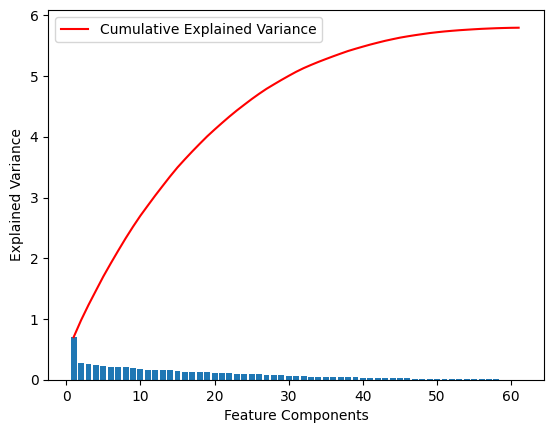

In [ ]:
plt.bar(range(1,len(pca1.explained_variance_ )+1), pca1.explained_variance_)
plt.ylabel('Explained Variance')
plt.xlabel('Feature Components')
plt.plot(range(1,len(pca1.explained_variance_ )+1),
         np.cumsum(pca1.explained_variance_),
         c='red',
         label = "Cumulative Explained Variance")
plt.legend(loc='upper left')

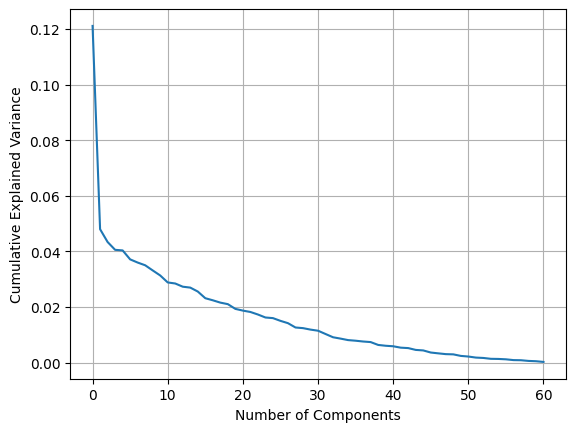

In [ ]:
plt.plot(pca1.explained_variance_ratio_)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid()
plt.show()

In [ ]:
pca2=PCA(0.95)

In [ ]:
x_pca2=pca2.fit_transform(X_train)

In [ ]:
x_pca2.shape

(7650, 41)

In [ ]:
pca2.n_components_

41